In [2]:
from sqlalchemy import create_engine
import pandas as pd

In [3]:
backend_directory = '/mnt/c/Users/archi/Desktop/larks/backend/'
import os
os.chdir(backend_directory)
from app import models, db, create_app
app = create_app()

Running locally - CORS has been enabled.


In [4]:
cnx = create_engine('sqlite:////mnt/c/Users/archi/Desktop/larks/backend/app.db').connect()

In [5]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
patients = pd.read_sql_table('patients', cnx)

target = pd.read_sql_table('patient', cnx)
target.drop('id', axis=1, inplace=True)
target.drop('DisorderSubclassPredicted', axis=1, inplace=True)

# For all patients with a REAL disorder subclass (X00012 27709 27501)
#       - with GENDER bloodCellCount RespiratoryRate HeartRate whiteBloodCellCount BloodTestResult
#       - and a MOTHER (MOTHER_SUBJECT_ID) != NONE
#         - with DOB pregnencyDueDate FolicAcidDetails numberOfPreviousAbortions
#       - and a FATHER (FATHER_SUBJECT_ID) != NONE
#         - with DOB
#       - we need to make them a row in this table (patients)

data = []

for index, row in patients.iterrows():
    # make a big object for patient here
    NEWPATIENT = {
      'PatientAge': relativedelta(datetime.now(), row['DOB']).years,
      'GenesInMothersSide': '', # DONE
      'InheritedFromFather': '', # DONE
      'MaternalGene': '', # DONE
      'PaternalGene': '', # DONE
      'BloodCellCount_mcL': '', # DONE
      'MothersAge': '', # DONE
      'FathersAge': '', # DONE
      'RespiratoryRate_breathsPerMin': '', # DONE
      'HeartRate_ratesPermin': '', # DONE
      'Gender': '', # DONE
      'BirthAsphyxia': '', # DONE
      'FolicAcidDetails_periConceptiona': '', # DONE 
      'HistoryOfSeriousMaternalIllness': '', # DONE
      'HistoryOfRadiationExposure_xRay': '', # DONE
      'HistoryOfSubstanceAbuse': '', # DONE
      'AssistedConception_IVF_ART': '', # DONE
      'HistoryOfAnomaliesInPreviousPregnancies': '', # DONE
      'NumberOfPreviousAbortions': '', # DONE
      'BirthDefects': '', # DONE
      'WhiteBloodCellCount_thousand_per_microliter': '', # DONE
      'BloodTestResult': '', # DONE
      'Symptom1': '', # DONE 
      'Symptom2': '', # DONE
      'Symptom3': '', # DONE
      'Symptom4': '', # DONE
      'Symptom5': '', # DONE
      'DisorderSubclass': '', # DONE
    }
    if models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ICD9_CODE='X00012').first() != None:
        # disorder is tay sachs
        NEWPATIENT['DisorderSubclass'] = 5 ## "Tay-Sachs"
        pass    
    elif models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ICD9_CODE='27709').first() != None:
        # disorder is Cystic fibrosis
        NEWPATIENT['DisorderSubclass'] = 0 ## "Cystic fibrosis"
        pass    
    elif models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ICD9_CODE='27501').first() != None:
        # disorder is Heredit hemochromatosis
        NEWPATIENT['DisorderSubclass'] = 6 ## "Hemochromatosis"
        pass    
    else:
        continue # not valid

    mother = None
    father = None

    # Check mother exists
    mQ = models.PATIENTS.query.filter_by(SUBJECT_ID=row['MOTHER_SUBJECT_ID']).all()
    if len(mQ) != 0:
        mother = mQ[0]
        x = datetime.strptime(str(row['DOB']), '%Y-%m-%d %H:%M:%S')
        y = datetime.strptime(str(mother.DOB), '%Y-%m-%d')
        # print()
        # print(row['DOB'])
        # print(mother.DOB)
        # break
        # Calculate Mothers age at birth
        NEWPATIENT['MothersAge'] = relativedelta(x, y).years
    else:
        continue # not valid


    # Check father exists
    fQ = models.PATIENTS.query.filter_by(SUBJECT_ID=row['FATHER_SUBJECT_ID']).all()
    if len(fQ) != 0:
        father = fQ[0]
        # Calculate Fathers age at birth
        x = datetime.strptime(str(row['DOB']), '%Y-%m-%d %H:%M:%S')
        y = datetime.strptime(str(father.DOB), '%Y-%m-%d')
        NEWPATIENT['FathersAge'] = relativedelta(x, y).years
    else:
        continue # not valid

    # Put Patient Gender in
    NEWPATIENT['Gender'] = 1 if row['GENDER'] == "M" else 0 # TODO: Check else = 2
    
    # Put patient bloodCellCount in
    cnt = models.LABEVENTS.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ITEMID='99001').first()
    if not cnt:
        continue # not valid
    NEWPATIENT['BloodCellCount_mcL'] = cnt.VALUENUM 
    # Put patient RespiratortyRate in
    cnt = models.CHARTEVENTS.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ITEMID='220210').first()
    if not cnt:
        continue # not valid
    NEWPATIENT['RespiratoryRate_breathsPerMin'] = 1 if cnt.VALUE == "Normal (30-60)" else 0
    # Put Patient HeartRate in
    cnt = models.CHARTEVENTS.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ITEMID='220045').first()
    if not cnt:
        continue # not valid
    NEWPATIENT['HeartRate_ratesPermin'] = 1 if cnt.VALUE == "Normal" else 0
    # Put Patient whiteBloodCellCount in
    cnt = models.LABEVENTS.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ITEMID='99002').first()
    if not cnt:
        continue # not valid
    NEWPATIENT['WhiteBloodCellCount_thousand_per_microliter'] = cnt.VALUENUM
    # Put Patient BloodTestResult in
    cnt = models.LABEVENTS.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ITEMID='43176').first()
    if not cnt:
        continue # not valid
    NEWPATIENT['BloodTestResult'] = 1 if cnt.FLAG == "slightly abnormal" else 0 if cnt.FLAG  == "normal" else 2 if cnt.FLAG =="inconclusive" else 3

    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ICD9_CODE='X0004').first()
    NEWPATIENT['Symptom1'] = 1 if cnt else 0
    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ICD9_CODE='X0005').first()
    NEWPATIENT['Symptom2'] = 1 if cnt else 0
    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ICD9_CODE='X0006').first()
    NEWPATIENT['Symptom3'] = 1 if cnt else 0
    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ICD9_CODE='X0007').first()
    NEWPATIENT['Symptom4'] = 1 if cnt else 0
    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ICD9_CODE='X0008').first()
    NEWPATIENT['Symptom5'] = 1 if cnt else 0

    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ICD9_CODE='X0003').first()
    NEWPATIENT['BirthDefects'] = 1 if cnt else 0

    cnt = models.NOTEEVENTS.query.filter_by(SUBJECT_ID=mother.SUBJECT_ID, DESCRIPTION='Self assessed previous number of abortions').first()
    if not cnt:
      continue # not valid
    NEWPATIENT['NumberOfPreviousAbortions'] = cnt.TEXT

    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=mother.SUBJECT_ID, ICD9_CODE='7618').first()
    if not cnt: # try other value
      cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=mother.SUBJECT_ID, ICD9_CODE='7619').first()
    NEWPATIENT['HistoryOfAnomaliesInPreviousPregnancies'] = 1 if cnt else 0

    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=mother.SUBJECT_ID, ICD9_CODE='V2385').first()
    NEWPATIENT['AssistedConception_IVF_ART'] = 1 if cnt else 0

    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=mother.SUBJECT_ID, ICD9_CODE='V113').first()
    if not cnt:
        cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=mother.SUBJECT_ID, ICD9_CODE='X0002').first()
    if not cnt:
        cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=father.SUBJECT_ID, ICD9_CODE='V113').first()
    if not cnt:
        cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=father.SUBJECT_ID, ICD9_CODE='X0002').first()
    NEWPATIENT['HistoryOfSubstanceAbuse'] = 1 if cnt else 0
    
    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=mother.SUBJECT_ID, ICD9_CODE='V153').first()
    if not cnt:
        cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=father.SUBJECT_ID, ICD9_CODE='V153').first()
    NEWPATIENT['HistoryOfRadiationExposure_xRay'] = 1 if cnt else 0

    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=mother.SUBJECT_ID, ICD9_CODE='7602').first()
    NEWPATIENT['HistoryOfSeriousMaternalIllness'] = 1 if cnt else 0

    cnt = models.CHARTEVENTS.query.filter_by(SUBJECT_ID=mother.SUBJECT_ID, ITEMID='5067').first()
    if not cnt:
        continue # Not Valid
    NEWPATIENT['FolicAcidDetails_periConceptiona'] = 1 if cnt.VALUE == 'Yes' else 0

    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ICD9_CODE='7685').first()
    if not cnt:
        cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ICD9_CODE='7686').first()
    if not cnt:
        cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=row['SUBJECT_ID'], ICD9_CODE='7689').first()
    NEWPATIENT['BirthAsphyxia'] = 1 if cnt else 0

    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=father.SUBJECT_ID, ICD9_CODE='V189').first()
    NEWPATIENT['PaternalGene'] = 1 if cnt else 0

    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=mother.SUBJECT_ID, ICD9_CODE='V189').first()
    NEWPATIENT['MaternalGene'] = 1 if cnt else 0
    
    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=father.SUBJECT_ID, ICD9_CODE='X0001').first() # TODO: if input has changed this needs to change
    NEWPATIENT['InheritedFromFather'] = 1 if cnt else 0

    cnt = models.DIAGNOSES_ICD.query.filter_by(SUBJECT_ID=mother.SUBJECT_ID, ICD9_CODE='X0001').first() # TODO: if input has changed this needs to change
    NEWPATIENT['GenesInMothersSide'] = 1 if cnt else 0

    data.append([
        NEWPATIENT['PatientAge'],
        NEWPATIENT['GenesInMothersSide'],
        NEWPATIENT['InheritedFromFather'],
        NEWPATIENT['MaternalGene'],
        NEWPATIENT['PaternalGene'],
        NEWPATIENT['BloodCellCount_mcL'],
        NEWPATIENT['MothersAge'],
        NEWPATIENT['FathersAge'],
        NEWPATIENT['RespiratoryRate_breathsPerMin'],
        NEWPATIENT['HeartRate_ratesPermin'],
        NEWPATIENT['Gender'],
        NEWPATIENT['BirthAsphyxia'],
        NEWPATIENT['FolicAcidDetails_periConceptiona'],
        NEWPATIENT['HistoryOfSeriousMaternalIllness'],
        NEWPATIENT['HistoryOfRadiationExposure_xRay'],
        NEWPATIENT['HistoryOfSubstanceAbuse'],
        NEWPATIENT['AssistedConception_IVF_ART'],
        NEWPATIENT['HistoryOfAnomaliesInPreviousPregnancies'],
        NEWPATIENT['NumberOfPreviousAbortions'],
        NEWPATIENT['BirthDefects'],
        NEWPATIENT['WhiteBloodCellCount_thousand_per_microliter'],
        NEWPATIENT['BloodTestResult'],
        NEWPATIENT['Symptom1'],
        NEWPATIENT['Symptom2'],
        NEWPATIENT['Symptom3'],
        NEWPATIENT['Symptom4'],
        NEWPATIENT['Symptom5'],
        NEWPATIENT['DisorderSubclass'],
    ])

In [6]:
target

,PatientAge,GenesInMothersSide,InheritedFromFather,MaternalGene,PaternalGene,BloodCellCount_mcL,MothersAge,FathersAge,RespiratoryRate_breathsPerMin,HeartRate_ratesPermin,...,NumberOfPreviousAbortions,BirthDefects,WhiteBloodCellCount_thousand_per_microliter,BloodTestResult,Symptom1,Symptom2,Symptom3,Symptom4,Symptom5,DisorderSubclass
0,0.0,1.0,0.0,1.0,1.0,7.260,18.0,51.0,1.0,1.0,...,2.0,0.0,5.82,3.0,1.0,0.0,1.0,1.0,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,6.998,69.0,43.0,1.0,1.0,...,4.0,0.0,6.69,2.0,0.0,1.0,1.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,6.998,69.0,43.0,1.0,1.0,...,4.0,0.0,6.69,2.0,0.0,1.0,1.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,0.0,6.998,69.0,43.0,1.0,1.0,...,4.0,0.0,6.69,2.0,0.0,1.0,1.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,6.998,69.0,43.0,1.0,1.0,...,4.0,0.0,6.69,2.0,1.0,1.0,0.0,0.0,1.0,0.0
5,0.0,0.0,1.0,0.0,0.0,6.998,69.0,43.0,1.0,1.0,...,4.0,0.0,6.69,2.0,1.0,1.0,0.0,0.0,1.0,0.0
6,0.0,0.0,1.0,0.0,0.0,6.998,69.0,43.0,0.0,0.0,...,4.0,0.0,6.69,2.0,1.0,1.0,0.0,0.0,1.0,0.0
7,0.0,0.0,1.0,0.0,0.0,6.998,69.0,43.0,0.0,0.0,...,4.0,1.0,6.69,2.0,1.0,1.0,0.0,0.0,1.0,0.0
8,5.0,1.0,0.0,1.0,0.0,6.998,69.0,43.0,0.0,0.0,...,4.0,1.0,6.69,2.0,1.0,1.0,0.0,0.0,1.0,0.0
9,5.0,1.0,0.0,1.0,0.0,9.000,28.0,25.0,0.0,0.0,...,4.0,1.0,6.69,2.0,1.0,1.0,0.0,0.0,1.0,0.0


In [7]:
data = [[float(item) for item in row] for row in data]
df = pd.DataFrame(data)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,3490.000000,3490.000000,3490.000000,3490.000000,3490.000000,3490.000000,3490.000000,3490.000000,3490.000000,3490.000000,...,3490.000000,3490.000000,3490.000000,3490.000000,3490.000000,3490.000000,3490.000000,3490.000000,3490.000000,3490.000000
mean,7.275931,0.577364,0.367908,0.585387,0.437536,4.902093,26.120630,36.555014,0.455301,0.454441,...,1.876791,0.549570,7.811319,1.424355,0.603725,0.558453,0.551862,0.508023,0.476504,2.844986
std,4.375578,0.494049,0.482305,0.492726,0.496154,0.199972,9.786635,12.495295,0.498069,0.497991,...,1.371100,0.497608,2.806628,1.065971,0.489193,0.496643,0.497374,0.500007,0.499519,2.676348
min,0.000000,0.000000,0.000000,0.000000,0.000000,4.235727,4.000000,6.000000,0.000000,0.000000,...,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000,0.000000,0.000000,4.765009,19.000000,27.000000,0.000000,0.000000,...,1.000000,0.000000,5.572519,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,1.000000,0.000000,1.000000,0.000000,4.900062,25.000000,38.000000,0.000000,0.000000,...,2.000000,1.000000,7.723361,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,5.000000
75%,11.000000,1.000000,1.000000,1.000000,1.000000,5.037447,33.000000,46.000000,1.000000,1.000000,...,3.000000,1.000000,10.093337,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000
max,14.000000,1.000000,1.000000,1.000000,1.000000,5.609829,51.000000,64.000000,1.000000,1.000000,...,4.000000,1.000000,12.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
targetColumn = 27
output_set = df[targetColumn]
input_set = df.drop(columns=[targetColumn])
X_train, X_test, Y_train, Y_test = train_test_split(input_set, output_set, test_size=0.2, random_state = 1)

model = svm.SVC(kernel='linear') # Linear Kernel
model.fit(X_train, Y_train)

prediction = model.predict(X_test)
acc = accuracy_score(Y_test, prediction)
acc

# this_dir = os.path.dirname(__file__)
# joblib.dump(model, f'{this_dir}/classifier-linear-svc-FROMDATABASE-inAPI-joblib-dump.joblib')

# response = make_response(jsonify({"msg": "Model created with accuracy = " + str(acc)}))
# response.status_code = 200
# return response

0.7607449856733525

In [10]:
# https://scikit-learn.org/stable/modules/model_evaluation.html#:~:text=3.3.2.5.%20Cohen%E2%80%99s%20kappa%C2%B6
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(Y_test, prediction)

0.5935322793240765

In [14]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(Y_test, prediction)

<Figure size 7680x5760 with 0 Axes>

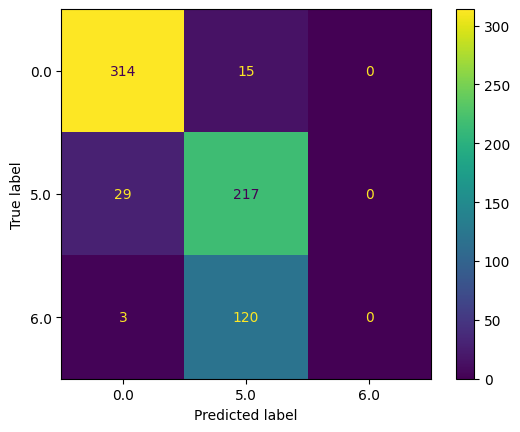

In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.figure(dpi=1200)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [30]:
from sklearn.metrics import classification_report
target_names = ['0', '5', '6']
print(classification_report(Y_test, prediction, target_names=target_names))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       329
           5       0.62      0.88      0.73       246
           6       0.00      0.00      0.00       123

    accuracy                           0.76       698
   macro avg       0.51      0.61      0.55       698
weighted avg       0.65      0.76      0.69       698



/mnt/c/Users/archi/Desktop/larks/backend/flask/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/archi/Desktop/larks/backend/flask/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/mnt/c/Users/archi/Desktop/larks/backend/flask/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av